In [1]:
import os 
os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
from loguru import logger

from models.cluster import KMeansClusterModel
from models.cluster import HierarchicalCluster

from utils.load import load_sequences, load_metadata
from utils.pitch import extract_pitch_based_features
from utils.pitch import plot_pca_variance
from utils.pitch import plot_clusters, plot_dendrogram

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# functions

In [ ]:
def extract_all_features(max_interval=12):
    """Extract pitch-based features from all sequences and return a dataframe."""

    sequences_df = load_sequences("data/sequences")
    records = []

    for idx, row in sequences_df.iterrows():
        seq = row["sequence"]
        features = extract_pitch_based_features(seq, max_interval=max_interval)

        if np.any(np.isnan(features)):
            continue  # skip bad sequences

        records.append({
            "id": idx,
            "features": np.array(features, dtype=float),
            "path": row["path"]
        })

    df = pd.DataFrame(records, index=[r["id"] for r in records]).sort_index()
    return df


def apply_pca(features_df, keep_variance=0.95):
    """Scale features and apply PCA."""

    X = np.vstack(features_df["features"].values)
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    pca = PCA(n_components=keep_variance, random_state=42)
    X_pca = pca.fit_transform(X_std)

    logger.info(
        f"PCA reduced from {X.shape[1]} → {X_pca.shape[1]} dims "
        f"({pca.explained_variance_ratio_.sum():.2%} variance kept)"
    )

    plot_pca_variance(pca)

    return X_pca

In [15]:
def main():
    features_df = extract_all_features()

    X_pca = apply_pca(features_df)

    model = KMeansClusterModel(n_clusters=4, max_iters=300, random_state=42)
    model.fit(X_pca)

    labels = model.labels_
    features_df["cluster"] = labels

    logger.info("K-Means cluster distribution:")
    logger.info(features_df["cluster"].value_counts())

    plot_clusters(X_pca, labels, dim=3, title="K-Means Clusters on PCA Features")

    return features_df

2025-11-19 10:06:14.979 | INFO     | utils.load:load_sequences:59 - Loading sequences from data/sequences with extension .npy
Loading sequences: 91it [00:00, 2651.75it/s]
2025-11-19 10:06:15.019 | SUCCESS  | utils.load:load_sequences:81 - Loaded 91 sequences from data/sequences
2025-11-19 10:06:15.129 | INFO     | __main__:apply_pca:35 - PCA reduced from 169 → 42 dims (95.23% variance kept)


                  id                                           sequence  \
id                                                                        
tt0026138  tt0026138  [36, 51, 81, 55, 75, 74, 62, 60, 62, 75, 72, 6...   
tt0029583  tt0029583  [60, 128, 69, 57, 53, 69, 53, 50, 60, 128, 69,...   
tt0032138  tt0032138  [39, 63, 70, 67, 63, 39, 46, 128, 51, 128, 55,...   
tt0040076  tt0040076  [55, 55, 55, 43, 57, 57, 57, 45, 55, 55, 55, 4...   
tt0045152  tt0045152  [41, 60, 53, 41, 81, 69, 77, 81, 128, 72, 69, ...   
...              ...                                                ...   
tt0418279  tt0418279  [72, 36, 43, 60, 67, 72, 75, 55, 39, 63, 70, 7...   
tt0499549  tt0499549  [61, 46, 128, 61, 46, 128, 61, 46, 128, 61, 46...   
tt0988045  tt0988045  [57, 50, 57, 50, 57, 50, 128, 57, 50, 57, 50, ...   
tt1104001  tt1104001  [28, 40, 52, 64, 40, 52, 40, 59, 40, 57, 40, 4...   
tt1375666  tt1375666  [72, 45, 57, 64, 52, 79, 43, 55, 71, 62, 78, 5...   

                        

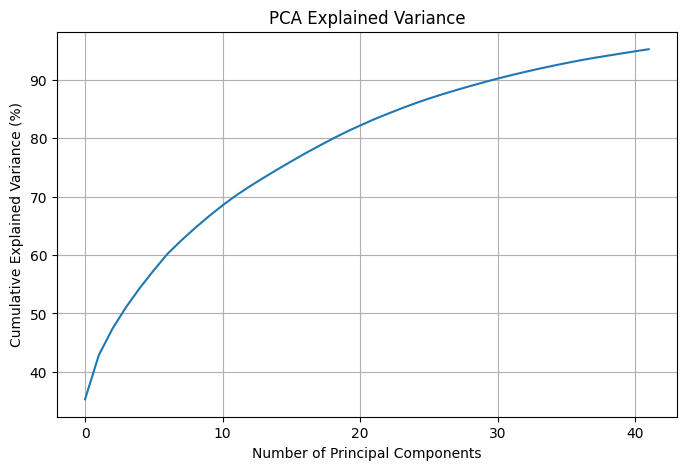

2025-11-19 10:06:15.166 | INFO     | __main__:main:12 - K-Means cluster distribution:
2025-11-19 10:06:15.167 | INFO     | __main__:main:13 - cluster
2    76
1    11
0     2
3     1
Name: count, dtype: int64


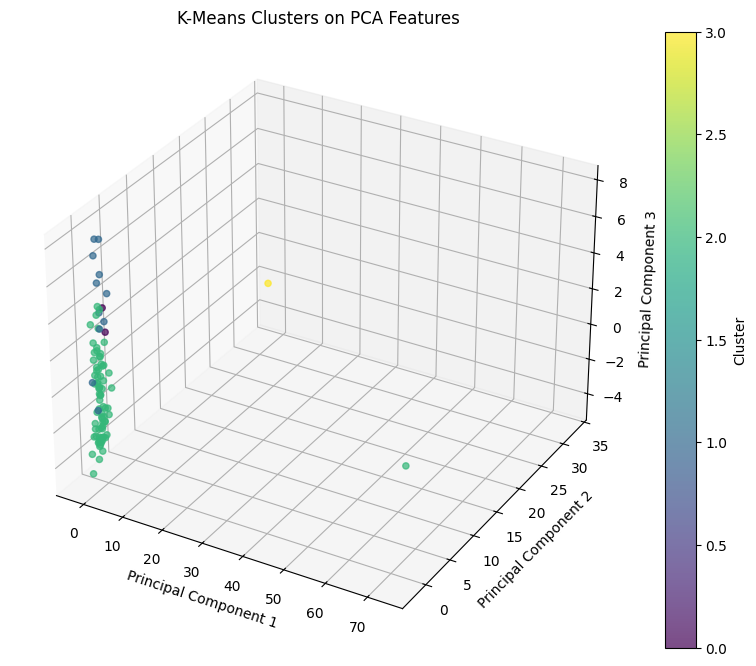

,id,features,path,cluster
tt0026138,tt0026138,"[0.15641568645811044, 0.0, 0.04652001563489285...",data/sequences/tt0026138_seq.npy,2
tt0029583,tt0029583,"[0.08338160893905106, 0.0, 0.16034265007517937...",data/sequences/tt0029583_seq.npy,2
tt0032138,tt0032138,"[0.10919929196499199, 0.0, 0.08594242980072472...",data/sequences/tt0032138_seq.npy,2
tt0040076,tt0040076,"[0.2394753224005805, 0.033081268883245904, 0.0...",data/sequences/tt0040076_seq.npy,2
tt0045152,tt0045152,"[0.20731756268375384, 0.0012861738107441613, 0...",data/sequences/tt0045152_seq.npy,2
...,...,...,...,...
tt0372824,tt0372824,"[0.0, 2.49103146e-314, 0.0, 2.4910315867e-314,...",data/sequences/tt0372824_seq.npy,2
tt0418279,tt0418279,"[0.20067069546215116, 0.0, 0.1053605156578263,...",data/sequences/tt0418279_seq.npy,2
tt0499549,tt0499549,"[0.0, 0.0, 0.0, 0.6931471805599453, 0.0, 0.0, ...",data/sequences/tt0499549_seq.npy,3
tt0988045,tt0988045,"[0.0, 9.4e-322, 0.0, 9.4e-322, 2.67e-322, 2.8e...",data/sequences/tt0988045_seq.npy,2


In [16]:
main()

# Hieracial Cluserting

In [11]:
def hier_clustering(method):
    features_df = extract_all_features()

    X_pca = apply_pca(features_df)

    model = HierarchicalCluster(method = method, n_clusters=4)
    model.fit(X_pca)

    labels = model.labels_
    features_df["cluster"] = labels

    logger.info("Hierarchical cluster distribution:")
    logger.info(features_df["cluster"].value_counts())

    plot_clusters(X_pca, labels, dim=3, title="Hierarchical Clusters on PCA Features")
    #plot_dendrogram(X_pca, method="ward", title="Dendrogram of PCA Features")

2025-11-19 10:02:32.731 | INFO     | utils.load:load_sequences:59 - Loading sequences from data/sequences with extension .npy
Loading sequences: 91it [00:00, 5953.17it/s]
2025-11-19 10:02:32.750 | SUCCESS  | utils.load:load_sequences:81 - Loaded 91 sequences from data/sequences
2025-11-19 10:02:32.865 | INFO     | __main__:apply_pca:34 - PCA reduced from 169 → 57 dims (95.22% variance kept)


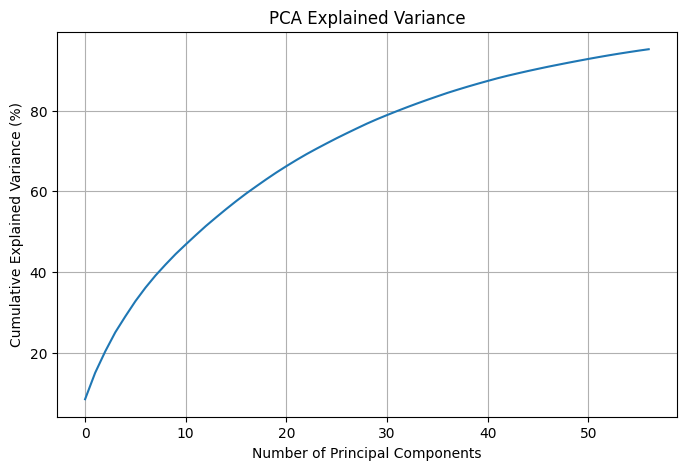

2025-11-19 10:02:32.897 | INFO     | __main__:hier_clustering:12 - Hierarchical cluster distribution:
2025-11-19 10:02:32.898 | INFO     | __main__:hier_clustering:13 - cluster
3    66
1    14
2     8
0     1
Name: count, dtype: int64


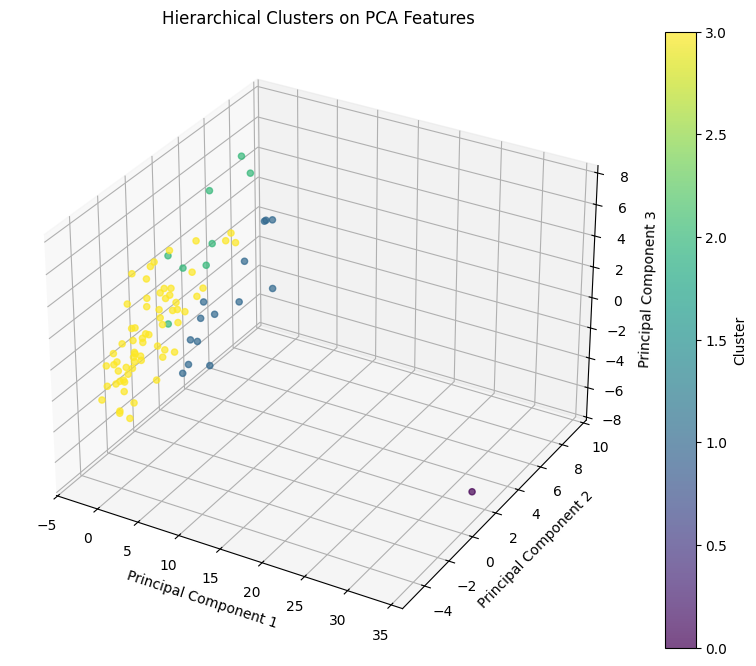

In [13]:
hier_clustering(method="divisive")